# Prep

## Dependencies

In [1]:
# General
import os
from os import path
import shutil
import glob
from datetime import datetime
from tqdm.notebook import tqdm

# Data processing
import pandas as pd
import numpy as np

# Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# ScikitLearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay)

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Images
import cv2

2023-04-27 15:54:12.518135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 15:54:19.013089: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-27 15:54:19.014755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

## Constants

In [44]:
CLASSES = ["normal", "covid"] # In order, first = 0, then 1, etc.
NUM_EPOCHS = 80
VALID_SPLIT = 0.1 # 10% of the TEST dataset so 8% overall
TEST_SPLIT = 0.2
LABEL_COLUMN = 'label'
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
RANDOM_STATE = 41
LEARNING_RATE =0.0001
MODEL_PREFIX = "CoroNet"
OUT_MODEL_PATH = f"./{MODEL_PREFIX}-models"

## Prepare Datasets

In [39]:
# Get paths
d1_data_path = path.join(os.getcwd(), "data/d1")

d2_data_path = path.join(os.getcwd(), "data/d2")

In [40]:
def get_image_df(data_path, labels_filter=CLASSES):
    labels = os.listdir(data_path)
    columns = ["image_path", LABEL_COLUMN]
    
    images = []
    for label in labels:
        if label not in labels_filter:
            continue
        label_image_paths = os.listdir(path.join(data_path, label))
        label_images = list(map(lambda im_path: [f"{label}/{im_path}", label], label_image_paths))
        images.extend(label_images)
        
    return pd.DataFrame(images, columns=columns)
        
def split_into_train_valid_test(df, test_split=TEST_SPLIT, valid_split=VALID_SPLIT):
    # Stratify split test dataset into test and validation
    full_train_df, test_df = train_test_split(df,
                                         test_size=test_split,
                                         shuffle=True,
                                         stratify=df[LABEL_COLUMN],
                                         random_state=RANDOM_STATE
                                        )

    train_df, valid_df = train_test_split(full_train_df,
                                         test_size=valid_split,
                                         shuffle=True,
                                         stratify=full_train_df[LABEL_COLUMN],
                                         random_state=RANDOM_STATE
                                        )
    return train_df, valid_df, test_df

In [41]:
df_1 = get_image_df(d1_data_path)
df_2 = get_image_df(d2_data_path)
display(df_1.sample(5).head())
display(df_2.sample(5).head())

,image_path,label
3303,normal/NORMAL-6543.png,normal
2524,normal/NORMAL-2139.png,normal
4694,normal/NORMAL-2924.png,normal
4052,normal/NORMAL-142.png,normal
2861,normal/NORMAL-5966.png,normal


,image_path,label
230,covid/COVID-495.png,covid
935,covid/COVID-102.png,covid
1859,normal/NORMAL-9914.png,normal
1185,normal/NORMAL-9664.png,normal
1040,covid/COVID-45.png,covid


In [42]:
train_df_1, valid_df_1, test_df_1 = split_into_train_valid_test(df_1)
train_df_2, valid_df_2, test_df_2 = split_into_train_valid_test(df_2)

## Load Dataset

In [49]:
#Train datagen here is a preprocessor
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   # validation_split = 0.2,
                                   fill_mode='constant')


flow_kwargs = {
    # 'directory': train_data_path,
    'x_col': 'image_path',
    'y_col': LABEL_COLUMN,
    'batch_size': BATCH_SIZE,
    'seed': RANDOM_STATE,
    'class_mode': 'categorical',
    'classes': CLASSES,
    'target_size': IMAGE_SIZE
}

#Test Datagen only rescales for model
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_batches_1 = train_datagen.flow_from_dataframe(dataframe=train_df_1,
                                                  directory=d1_data_path, shuffle=True, **flow_kwargs)

valid_batches_1 = train_datagen.flow_from_dataframe(dataframe=valid_df_1,
                                                  directory=d1_data_path, shuffle=False, **flow_kwargs)

test_batches_1 = test_datagen.flow_from_dataframe(dataframe=test_df_1,
                                                directory=d1_data_path, shuffle=False, **flow_kwargs)

full_1 = test_datagen.flow_from_dataframe(dataframe=df_1,
                                                directory=d1_data_path, shuffle=False, **flow_kwargs)

train_batches_2 = train_datagen.flow_from_dataframe(dataframe=train_df_2,
                                                  directory=d2_data_path, shuffle=True, **flow_kwargs)

valid_batches_2 = train_datagen.flow_from_dataframe(dataframe=valid_df_2,
                                                  directory=d2_data_path, shuffle=False, **flow_kwargs)

test_batches_2 = test_datagen.flow_from_dataframe(dataframe=test_df_2,
                                                directory=d2_data_path, shuffle=False, **flow_kwargs)

full_2 = test_datagen.flow_from_dataframe(dataframe=df_2,
                                                directory=d2_data_path, shuffle=False, **flow_kwargs)


DATASETS_1 = {
    'train_1': train_batches_1,
    "validation_1": valid_batches_1,
    'test_1': test_batches_1,
}

DATASETS_2 = {
    'train_2': train_batches_2,
    "validation_2": valid_batches_2,
    'test_2': test_batches_2,
}

FULL_DATASET_1 = full_1
FULL_DATASET_2 = full_2

DATASETS = {
    **DATASETS_1,
    **DATASETS_2
}

Found 3562 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.
Found 4948 validated image filenames belonging to 2 classes.
Found 1644 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 457 validated image filenames belonging to 2 classes.
Found 2284 validated image filenames belonging to 2 classes.


# EDA

In [8]:
print(train_batches_1.class_indices)

{'normal': 0, 'covid': 1}


In [9]:
print(f"Train dataset 1 length: {len(train_df_1)}")
print(f"Valid dataset 1 length: {len(valid_df_1)}")
print(f"Test dataset 1 length: {len(test_df_1)}")

Train dataset 1 length: 3562
Valid dataset 1 length: 396
Test dataset 1 length: 990


In [10]:

print(f"Train dataset 2 length: {len(train_df_2)}")
print(f"Valid dataset 2 length: {len(valid_df_2)}")
print(f"Test dataset 2 length: {len(test_df_2)}")

Train dataset 2 length: 1644
Valid dataset 2 length: 183
Test dataset 2 length: 457


In [11]:
xb, yb = train_batches_1.next()
xb.shape,yb.shape

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


((32, 150, 150, 3), (32, 2))

In [12]:
xb, yb = train_batches_2.next()
xb.shape,yb.shape

((32, 150, 150, 3), (32, 2))

In [13]:
def display_class_sample(df, data_path, num_samples_per_class=3, middle_image=1):
    fig, axs = plt.subplots(2, num_samples_per_class, figsize = (6*num_samples_per_class, 3*4))

    for ax_row, (label, data) in zip(axs, df.sort_values([LABEL_COLUMN]).groupby(LABEL_COLUMN)):
        ax_row[middle_image].set_title(label, fontsize = 15)
        for ax, (idx, instance) in zip(ax_row, data.sample(num_samples_per_class).iterrows()):       
            _path = path.join(data_path, instance['image_path'])
            image = cv2.imread(_path)
            ax.imshow(image)
            ax.axis('off')

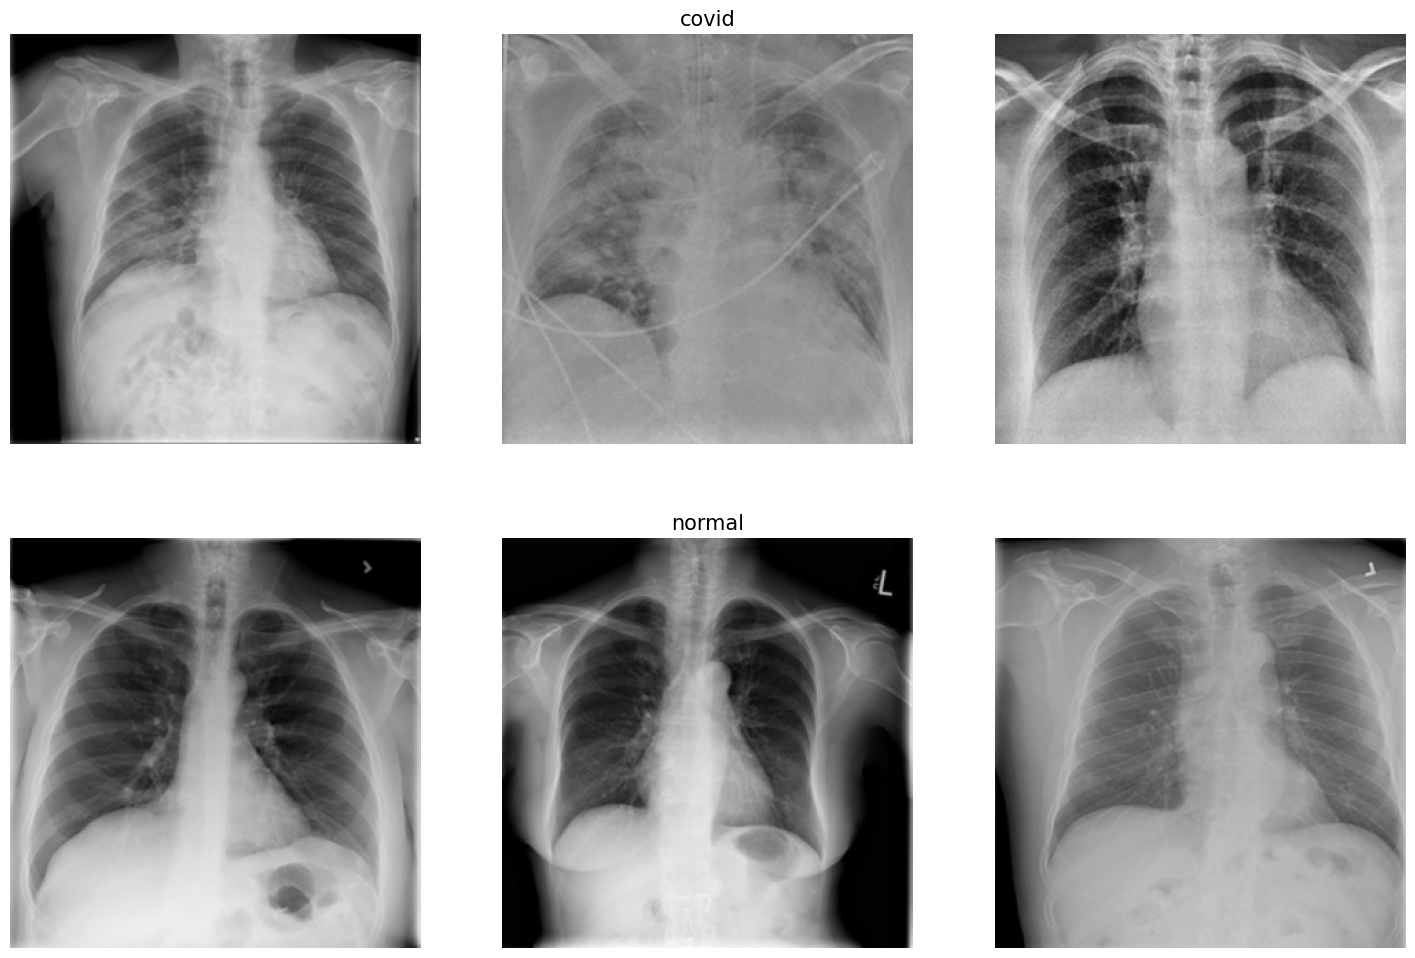

In [14]:
display_class_sample(train_df_1, d1_data_path)

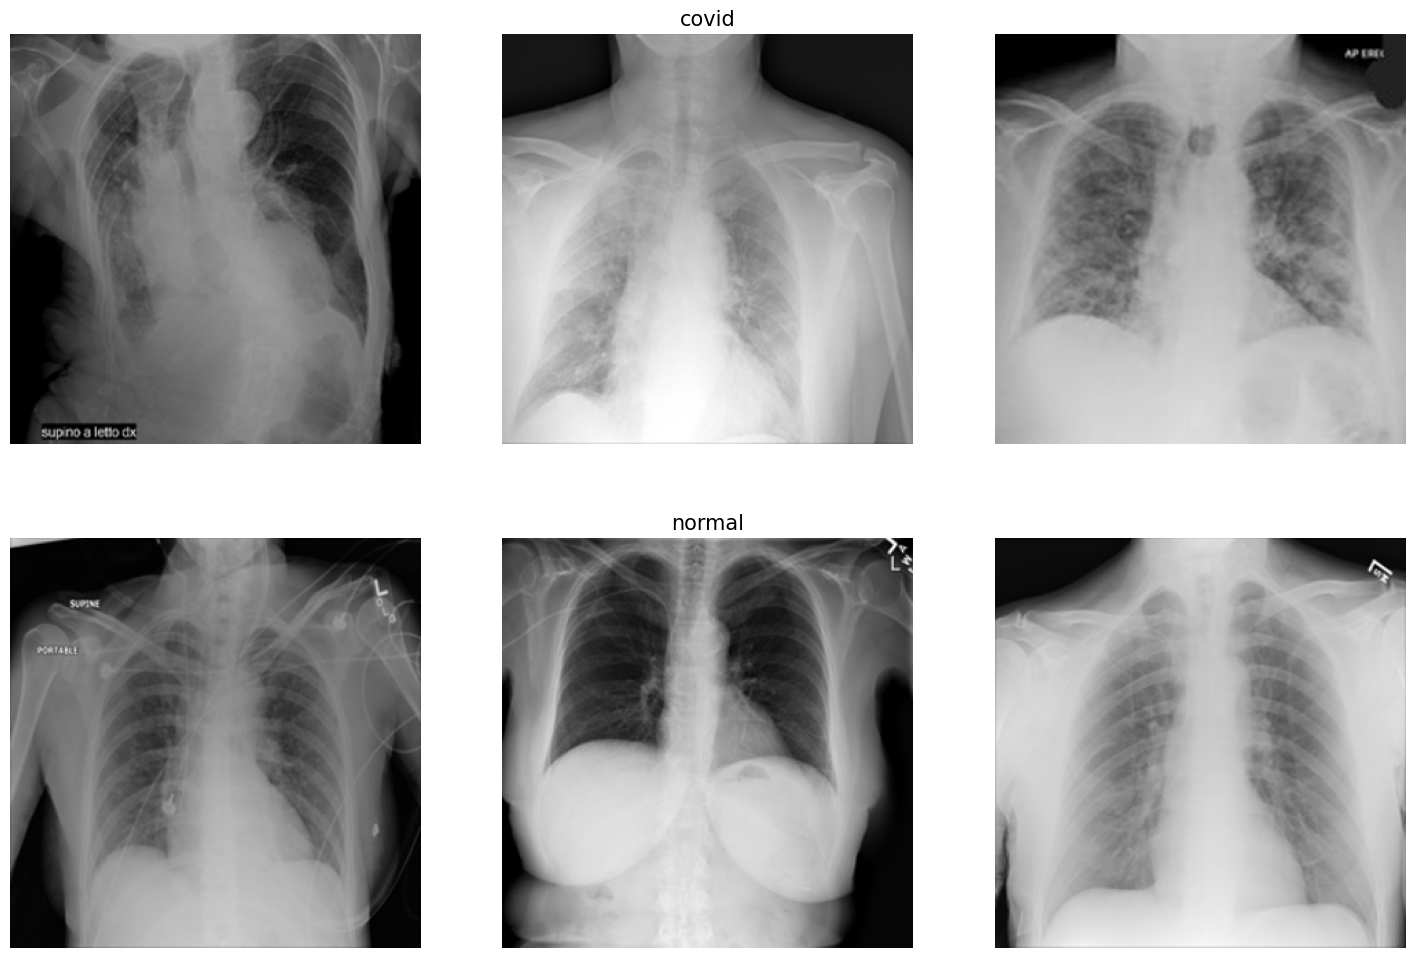

In [15]:
display_class_sample(train_df_2, d2_data_path)

# Train Model

## Build CoroNet (Xception with additional layers)

In [16]:
def build_model(summary=True):
    conv_base = tf.keras.applications.Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(*IMAGE_SIZE, 3))

    conv_base.trainable = True

    model = tf.keras.models.Sequential()
    model.add(conv_base)

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(len(CLASSES), activation=None))
    # model.add(layers.Dense(len(CLASSES), activation='softmax'))

    model.build()

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
                  metrics=['accuracy'])
    if summary:
        print(model.summary())
        
    return model

In [17]:
model_1 = build_model(summary=True)
model_2 = build_model(summary=False)

2023-04-27 15:54:32.736611: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-27 15:54:32.736691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (expensive-2): /proc/driver/nvidia/version does not exist
2023-04-27 15:54:32.739176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 33,969,450
Trainable params: 33,914,922
Non-trainable params: 54,528
_________________________________________________________________
None


## Fit Model

In [18]:
def train_model_and_save_results(model, *args, name=None, out_path=OUT_MODEL_PATH, out_time=None, save_final=True, **kwargs):
    if not name:
        raise Exception("Must supply name when training multiple models")
        
    if not out_time:
        out_time = datetime.now()
    out_path = path.join(out_path, out_time.strftime("%Y-%m-%dT%H:%M"))
    os.makedirs(out_path, exist_ok=True)
    
    save_model = tf.keras.callbacks.ModelCheckpoint(
        f"{out_path}/"+ name + "-{epoch:04d}-{accuracy:.2f}.tf",
        monitor = "val_loss",
        mode='min',
        verbose=0,
        save_weights_only=True,
        save_best_only=True
    )
    history_logger = tf.keras.callbacks.CSVLogger(path.join(out_path, name+"-train-log.csv"), separator=",", append=False)
    
    callbacks=kwargs.pop("callbacks", [])
    callbacks.append(save_model)
    callbacks.append(history_logger)

    history = model.fit(callbacks=callbacks, *args, **kwargs)
    np.save(path.join(out_path, name+"-history.npy"), history.history)
    
    # Save final model
    last_accuracy = history.history['accuracy'][-1]
    final_out_path = f"{out_path}/" + name +"-last-{accuracy:.2f}.tf".format(accuracy=last_accuracy)
    model.save_weights(final_out_path)
    
    return history.history

def load_model(model, model_path, checkpoint_name, history_name="history.npy"):
    model_path = path.join(OUT_MODEL_PATH, model_path)
    checkpoint_path = path.join(model_path, checkpoint_name)
    history_path = path.join(model_path, history_name)
    model.load_weights(checkpoint_path)
    history = np.load(history_path, allow_pickle='TRUE').item()
    return history
    
def train_together():
    """
    Only used to synchronize clocks for output models into the same folder
    """
    out_time = datetime.now()
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
                           mode='min', restore_best_weights=True)]

    try:
        history_1 = train_model_and_save_results(model_1, train_batches_1,
                                 name=f"{MODEL_PREFIX}-1",
                                 out_time=out_time,
                                 validation_data=valid_batches_2,
                                 epochs=NUM_EPOCHS,
                                 workers=1,
                                 callbacks=callbacks
                            )
    except Exception as e:
        print(f"Failed to train model_1: {e}")
        
    try:
        history_2 = train_model_and_save_results(model_2, train_batches_2,
                             name=f"{MODEL_PREFIX}-2",
                             out_time=out_time,
                             validation_data=valid_batches_2,
                             epochs=NUM_EPOCHS,
                             workers=1,
                             callbacks=callbacks
                            )
    except Exception as e:
        print(f"Failed to train model_2: {e}")
    
    return history_1, history_2

In [22]:
LOAD_MODEL_1 = True

if LOAD_MODEL_1:
    history_1 = load_model(model_1, "2023-04-25T20:33", "CoroNet-1-last-0.98.tf", history_name=f"{MODEL_PREFIX}-1-history.npy")
    pass
else:    
    history_1 = train_model_and_save_results(model_1, train_batches_1,
                                 name=f"{MODEL_PREFIX}-1",
                                 out_time=datetime.now(),
                                 validation_data=valid_batches_1,
                                 epochs=NUM_EPOCHS,
                                 workers=1,)
                                 # class_weight=class_weights)

In [35]:
LOAD_MODEL_2 = True

if LOAD_MODEL_2:
    history_2 = load_model(model_2, "2023-04-25T20:33", "CoroNet-2-0018-0.97.tf", history_name=f"{MODEL_PREFIX}-2-history.npy")
    pass
else:
    history_2 = train_model_and_save_results(model_2, train_batches_2,
                                 name=f"{MODEL_PREFIX}-2",
                                 out_time=datetime.now(),
                                 validation_data=valid_batches_2,
                                 epochs=NUM_EPOCHS,
                                 workers=1,)
                                 # class_weight=class_weights)

In [23]:
# history_1, history_2 = train_together()

Epoch 1/80


2023-04-25 20:33:53.308443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


112/112 [==============================] - 43s 266ms/step - loss: 0.4957 - accuracy: 0.7841 - val_loss: 0.5141 - val_accuracy: 0.7978
Epoch 2/80
112/112 [==============================] - 27s 244ms/step - loss: 0.2790 - accuracy: 0.8891 - val_loss: 0.4008 - val_accuracy: 0.8470
Epoch 3/80
112/112 [==============================] - 26s 229ms/step - loss: 0.2176 - accuracy: 0.9141 - val_loss: 0.4121 - val_accuracy: 0.8415
Epoch 4/80
112/112 [==============================] - 27s 243ms/step - loss: 0.1844 - accuracy: 0.9228 - val_loss: 0.3717 - val_accuracy: 0.8743
Epoch 5/80
112/112 [==============================] - 26s 228ms/step - loss: 0.1683 - accuracy: 0.9284 - val_loss: 0.4491 - val_accuracy: 0.8361
Epoch 6/80
112/112 [==============================] - 26s 229ms/step - loss: 0.1485 - accuracy: 0.9458 - val_loss: 0.3740 - val_accuracy: 0.8743
Epoch 7/80
112/112 [==============================] - 28s 247ms/step - loss: 0.1221 - accuracy: 0.9514 - val_loss: 0.2786 - val_accuracy: 0.9

# Evaluate

In [24]:
def get_pred_and_truth_not_shuffled(model, batches, single_binary_neuron=False):
    """
    This can only be used if the dataset is not shuffled
    """
    preds = model.predict(batches)
    if single_binary_neuron:
        # For single neuron with binary class probabily output
        y_pred = np.where(preds > 0.5, 1, 0)
    else:
        # For multi class or binary class using 2 neurons
        y_pred = np.argmax(preds, axis=-1)
    y_true = batches.classes
    return y_pred, y_true


def get_pred_and_truth(model, batches, single_binary_neuron=False):
    """
    This is required if the dataset is shuffled. You can't use batches.classes as the indexes are all wrong.
    Instead you get each batch, one at a time and process 
    """
    
    batches.reset()
    y_pred_batches = []  # store predicted labels
    y_true_batches = []  # store true labels
    
    for idx in tqdm(range(len(batches))):
        img_batch, y_batch = batches[idx]
        
        preds_batch = model.predict(img_batch, verbose=0)
        
        if single_binary_neuron:
            # For single neuron with binary class probabily output
            y_pred_batch = np.where(preds_batch > 0.5, 1, 0)
        else:
            # For multi class or binary class using 2 neurons
            y_pred_batch = np.argmax(preds_batch, axis=-1)
            
        y_true_batch = np.argmax(y_batch,-1)
        
        
        y_pred_batches.append(y_pred_batch)
        y_true_batches.append(y_true_batch)

    y_true = tf.concat([item for item in y_true_batches], axis = 0)
    y_pred = tf.concat([item for item in y_pred_batches], axis = 0)
    
    return y_pred, y_true

def evaluate_metrics(name, y_pred, y_true, round_to=6, plot=True):
    # Get confusion matrix and standard metrics for display in dataframe
    # Metrics calculated with Sklearn where possible
    cm = confusion_matrix(y_true, y_pred)
    conf = ConfusionMatrixDisplay(cm)
    specificity = round((cm[0,0]/(cm[0,0] + cm[0,1])),round_to)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    
    metrics = []
    metrics.append(["Accuracy", round(accuracy_score(y_true, y_pred),round_to)]) 
    metrics.append(["Recall", round(recall_score(y_true, y_pred),round_to)]) # TP/P
    metrics.append(["Specificity", specificity]) # TN/N
    metrics.append(["Precision", round(precision_score(y_true, y_pred),round_to)]) # TP/TP+FP
    metrics.append(["F1 Score", round(f1_score(y_true, y_pred),round_to)]) # 2 * (precision + recall) / (precison * recall)
    metrics = pd.DataFrame(data=metrics, columns=["Metric", "Score"])

    if plot:
        print(f"\n----------------------------- Classification report for {name} dataset -----------------------------\n")
        display(metrics)
        conf.plot()
        plt.show()
        roc.plot()
        plt.show()
        
    return metrics, conf

def evaluate_on_dataset(model, dataset, dataset_name, plot=True):
    y_pred, y_true = get_pred_and_truth(model, dataset)
    return evaluate_metrics(dataset_name, y_pred, y_true, plot=plot)

def evaluate_on_all_datasets(model, datasets=DATASETS):
    for name, d in datasets.items():
        metrics, conf = evaluate_on_dataset(model, d, name, plot=True)

def plot_loss_accuracy_curves(history, plot=True, limit_epochs=None):
    """
    Takes history.history
    """
    fig, axes = plt.subplots(1, 2, figsize=(16,8))

    
    for metric, ax in zip(['loss', 'accuracy'], axes):
        if not limit_epochs:
            limit_epochs = len(history[metric])
        ax.plot(history[metric][:limit_epochs])
        ax.plot(history[f'val_{metric}'][:limit_epochs])
        ax.set_title(f'{metric.title()}')
        ax.set_ylabel(metric)
        ax.set_xlabel('Epoch')
        ax.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

## Model 1 (Trained on Dataset 1)

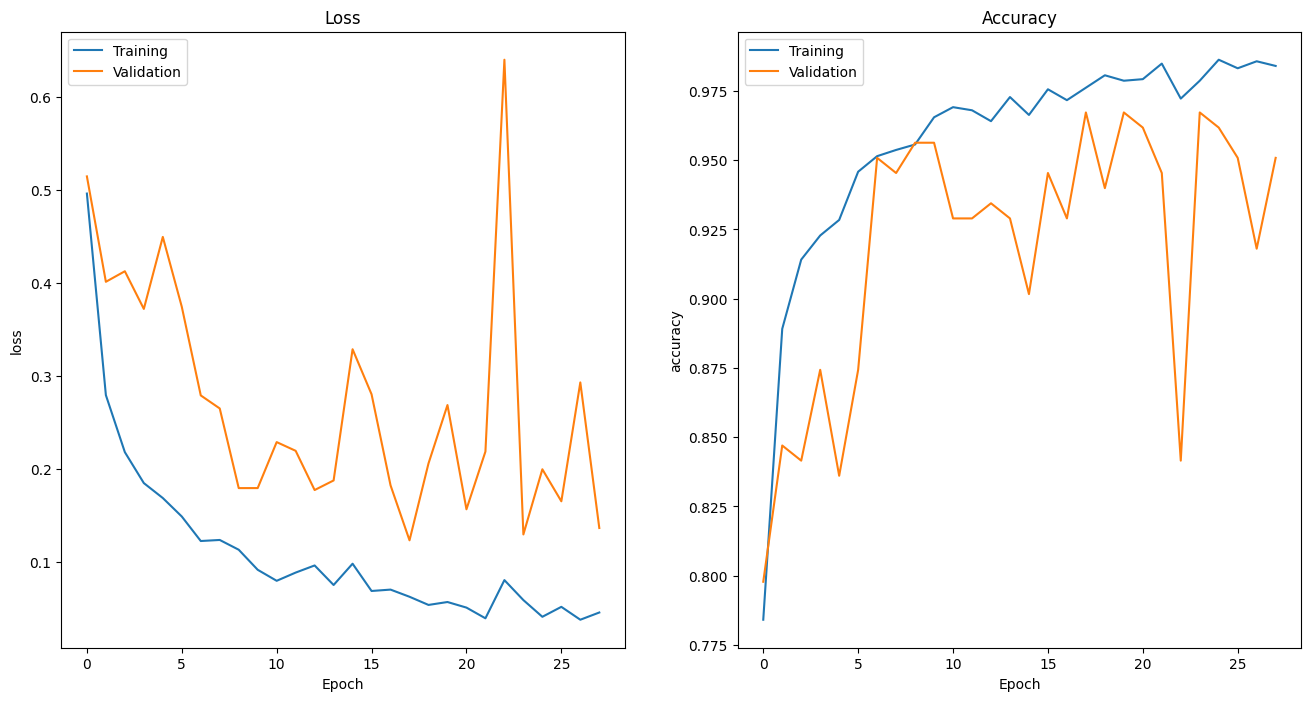

In [25]:
plot_loss_accuracy_curves(history_1, plot=True)

  0%|          | 0/112 [00:00<?, ?it/s]


----------------------------- Classification report for train_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.988209
1,Recall,0.982594
2,Specificity,0.993824
3,Precision,0.993754
4,F1 Score,0.988142


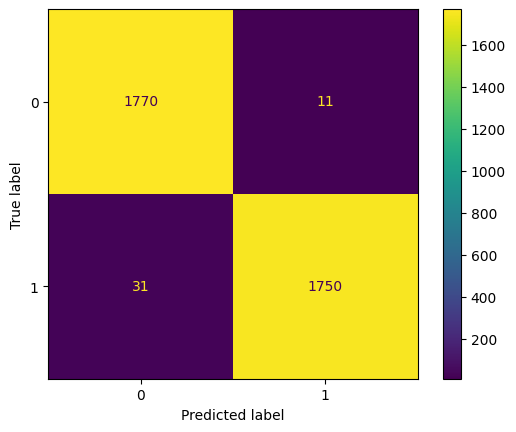

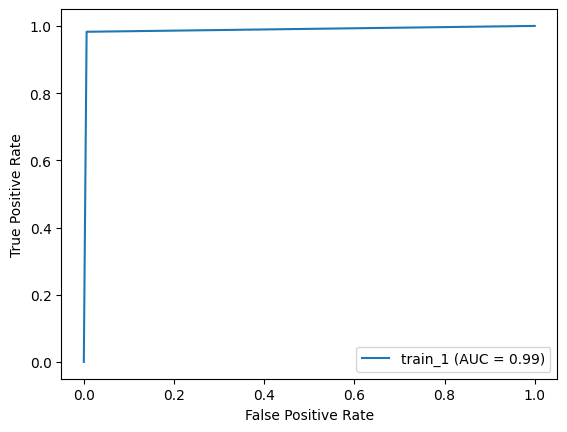

  0%|          | 0/13 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "



----------------------------- Classification report for validation_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.977273
1,Recall,0.959596
2,Specificity,0.994949
3,Precision,0.994764
4,F1 Score,0.976864


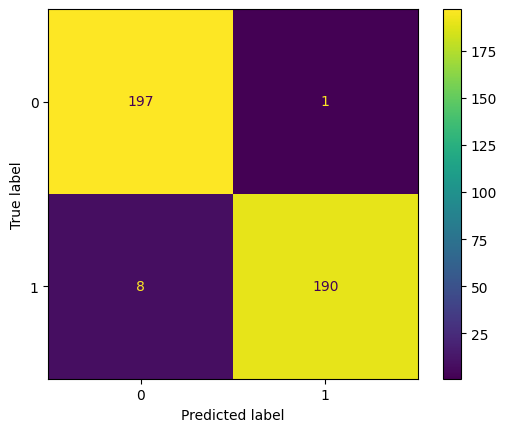

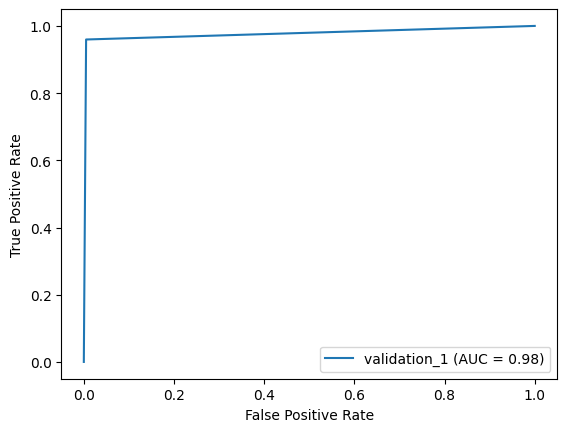

  0%|          | 0/31 [00:00<?, ?it/s]


----------------------------- Classification report for test_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.968687
1,Recall,0.947475
2,Specificity,0.989899
3,Precision,0.989451
4,F1 Score,0.968008


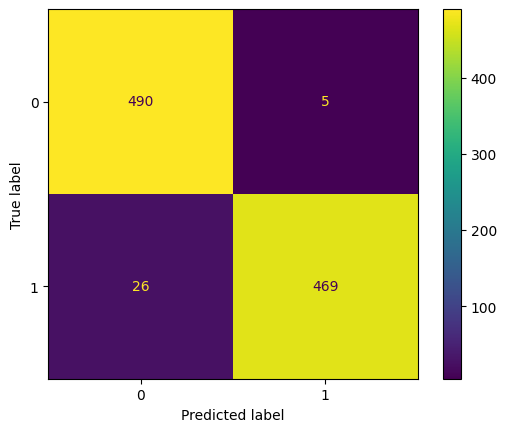

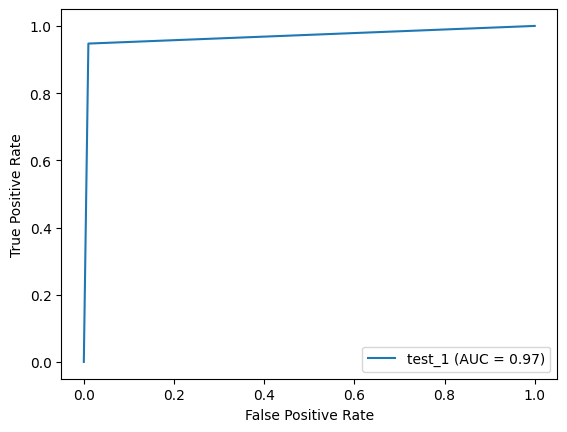

In [26]:
evaluate_on_all_datasets(model_1, datasets=DATASETS_1)

  0%|          | 0/72 [00:00<?, ?it/s]


----------------------------- Classification report for Dataset 2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.955342
1,Recall,0.917688
2,Specificity,0.992995
3,Precision,0.992424
4,F1 Score,0.953594


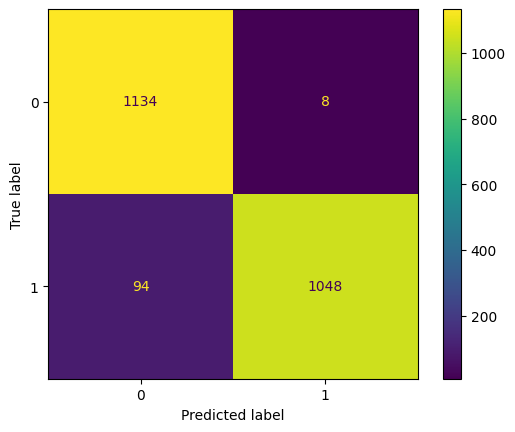

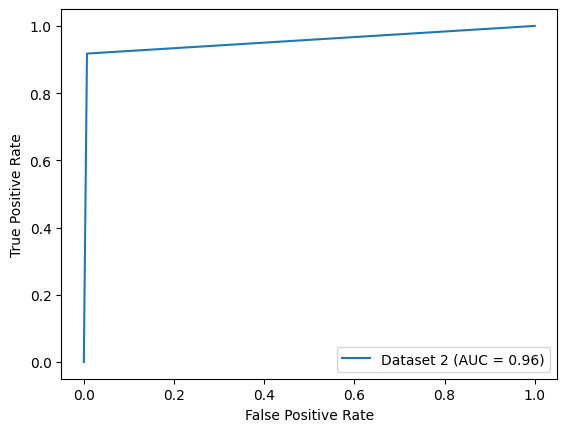

In [27]:
metrics, conf = evaluate_on_dataset(model_1, FULL_DATASET_2, "Dataset 2", plot=True)

## Model 2 (Trained on Dataset 2)

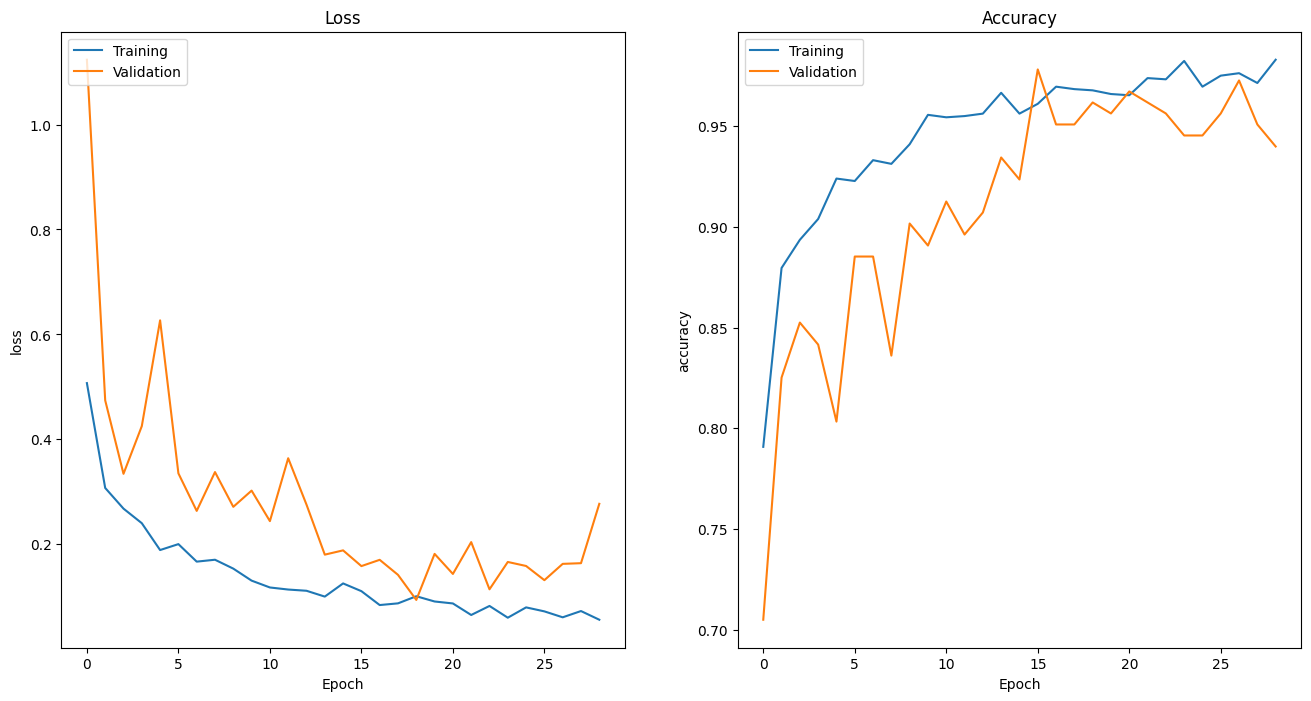

In [50]:
plot_loss_accuracy_curves(history_2, plot=True)

  0%|          | 0/52 [00:00<?, ?it/s]


----------------------------- Classification report for train_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.959246
1,Recall,0.934307
2,Specificity,0.984185
3,Precision,0.983355
4,F1 Score,0.958203


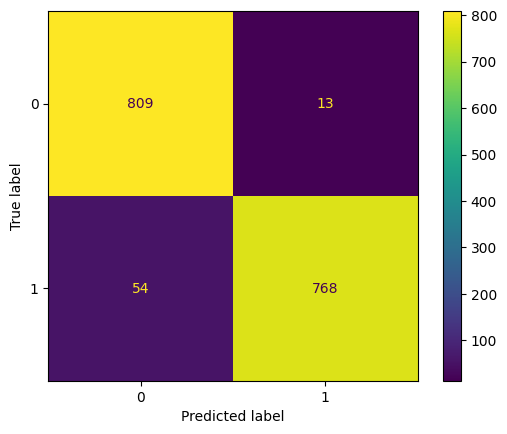

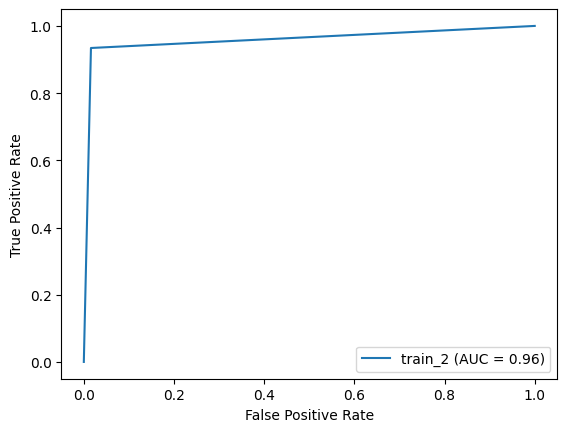

  0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "



----------------------------- Classification report for validation_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.956284
1,Recall,0.934783
2,Specificity,0.978022
3,Precision,0.977273
4,F1 Score,0.955556


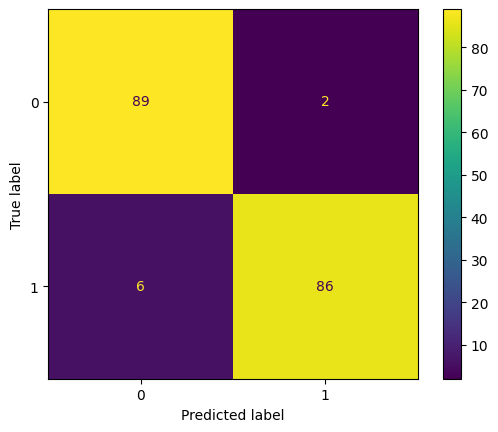

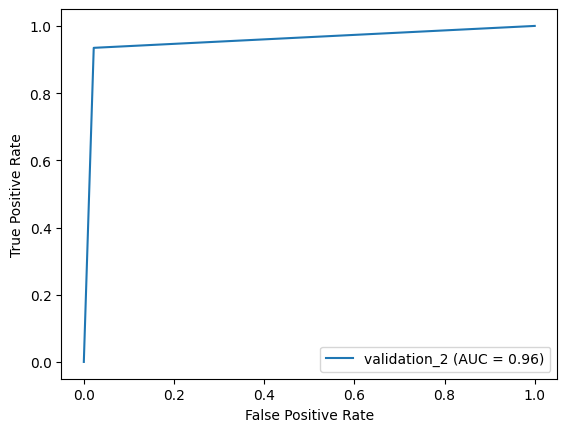

  0%|          | 0/15 [00:00<?, ?it/s]


----------------------------- Classification report for test_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.954048
1,Recall,0.916667
2,Specificity,0.991266
3,Precision,0.990521
4,F1 Score,0.952164


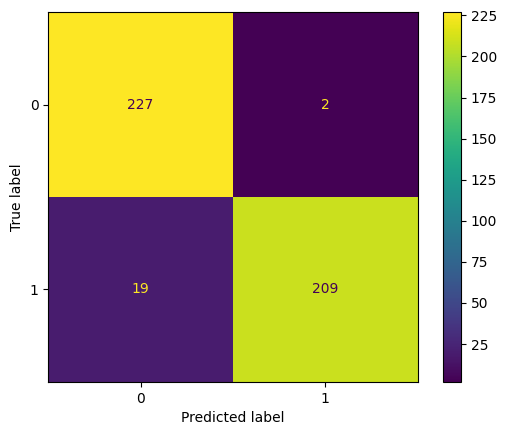

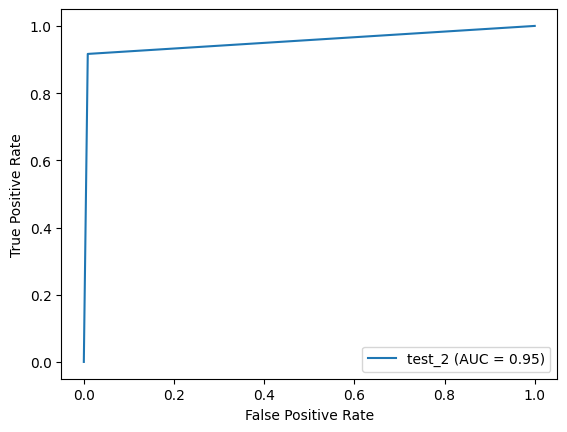

In [54]:
evaluate_on_all_datasets(model_2, datasets=DATASETS_2)

  0%|          | 0/155 [00:00<?, ?it/s]


----------------------------- Classification report for Dataset 1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.784762
1,Recall,0.704527
2,Specificity,0.864996
3,Precision,0.839191
4,F1 Score,0.765985


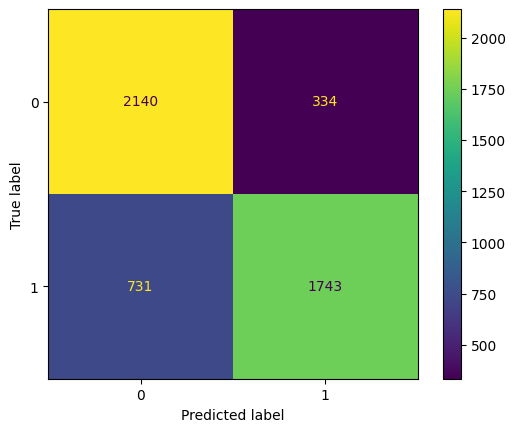

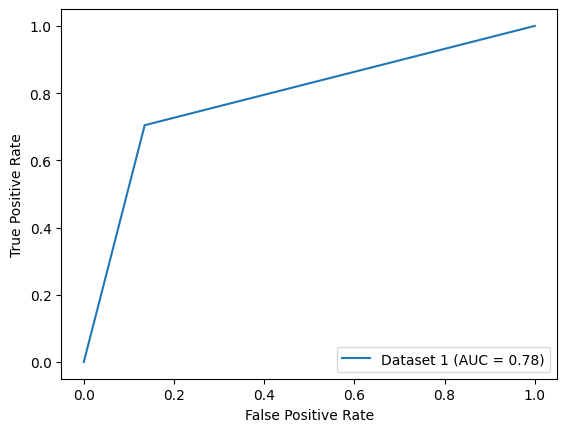

In [55]:
metrics, conf = evaluate_on_dataset(model_2, FULL_DATASET_1, "Dataset 1", plot=True)